<a href="https://colab.research.google.com/github/meetAmarAtGithub/Reva_NLPandText-Analytics/blob/main/ai03_TRIM02_Module06_NLP%26Text_Analytics_Assignment3_Disaster_Tweet_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/My Drive/Colab Notebooks/Reva/5_NLP_TextAnalytics"

/content/gdrive/My Drive/Colab Notebooks/Reva/5_NLP_TextAnalytics


In [4]:
# Transformers installation
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 41.4 MB/s 
     |████████████████████████████████| 101 kB 10.5 MB/s 
     |████████████████████████████████| 596 kB 53.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

import numpy as np
import pandas as pd
import string
!pip install text_hammer
import text_hammer as th
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS
from collections import defaultdict
#%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from transformers import AutoTokenizer,TFBertModel

max_len = 36

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import Word 
from wordcloud import WordCloud

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# <font color="green">**Data Pre-processing**</font>

In [18]:
disaster_file = '/content/gdrive/My Drive/Colab Notebooks/Reva/5_NLP_TextAnalytics/Disaster_train.csv'

In [8]:
import chardet
with open(disaster_file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [10]:
df = pd.read_csv(disaster_file,encoding='ISO-8859-1')
df.tail(5)

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [52]:
disaster = df[['text','target']]
disaster.head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [53]:
disaster.shape

(7613, 2)

### <font color="blue">**Remove Stopwords and Delimeter**</font>

In [54]:
def text_process(mess):
    nopunc =[char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])


disaster['text'] = disaster['text'].apply(text_process)
disaster.head(5)

,text,target
0,Deeds Reason earthquake May ALLAH Forgive us,1
1,Forest fire near La Ronge Sask Canada,1
2,residents asked shelter place notified officer...,1
3,13000 people receive wildfires evacuation orde...,1
4,got sent photo Ruby Alaska smoke wildfires pou...,1


In [55]:
disaster.shape

(7613, 2)

### <font color="blue">**Lemmatization**</font><br/>In simpler terms, it is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors. For example, lemmatization would correctly identify the base form of ‘caring’ to ‘care’, whereas, stemming would cutoff the ‘ing’ part and convert it to car. Lemmatization can be implemented in python by using Wordnet Lemmatizer, Spacy Lemmatizer, TextBlob, Stanford CoreNLP

In [56]:
lemmatizer = WordNetLemmatizer()

print('With out Lammetization - ', disaster['text'][2])

disaster['text'] = disaster['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
print('With Lemmatization -     ',  disaster['text'][2])

disaster.head(5)

With out Lammetization -  residents asked shelter place notified officers evacuation shelter place orders expected
With Lemmatization -      resident asked shelter place notified officer evacuation shelter place order expected


,text,target
0,Deeds Reason earthquake May ALLAH Forgive u,1
1,Forest fire near La Ronge Sask Canada,1
2,resident asked shelter place notified officer ...,1
3,13000 people receive wildfire evacuation order...,1
4,got sent photo Ruby Alaska smoke wildfire pour...,1


### <font color="blue"> **Remove links from the dataset.** <br> **Remove special characters or symbols from the dataset.** <br> **Remove numbers or alphanumerical characters from the dataset.**</font>

In [57]:
disaster['text'] = disaster['text'].str.replace(r'([\w\.-]+)@([\w\.-]+)',' ') #remove email addresses
disaster['text'] = disaster['text'].str.replace(r'[^\w\s]',' ') #remove punctuations and special chareters from dataset
disaster['text'] = disaster['text'].str.replace(r'(https|http)?:\/\/(\w|\.|\_|\/|\?|\=|\&|\%)*\b', ' ') # Remove links from the dataset.
disaster['text'] = disaster['text'].str.replace(r'[^\w]', ' ') #Remove not alphanumeric symbols white spaces

disaster.head(5)

,text,target
0,Deeds Reason earthquake May ALLAH Forgive u,1
1,Forest fire near La Ronge Sask Canada,1
2,resident asked shelter place notified officer ...,1
3,13000 people receive wildfire evacuation order...,1
4,got sent photo Ruby Alaska smoke wildfire pour...,1


## <font color="blue">**WORD CLOUD**</font>:

<Figure size 864x720 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

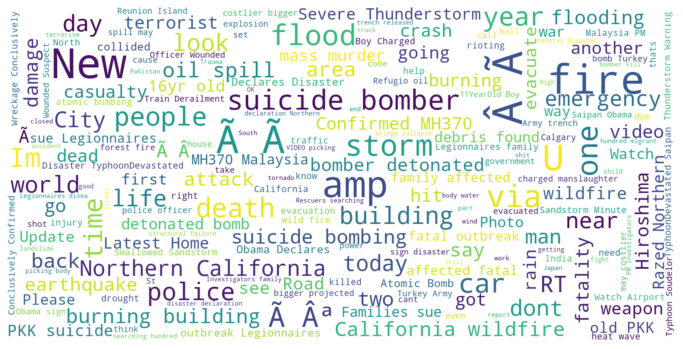

In [59]:
#Disaster Tweet wordcloud for which target is 1
disaster_message = disaster[disaster.target == 1]
spam_string = []
for t in disaster_message.text:
    spam_string.append(t)
disaster_string = pd.Series(spam_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<Figure size 864x720 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

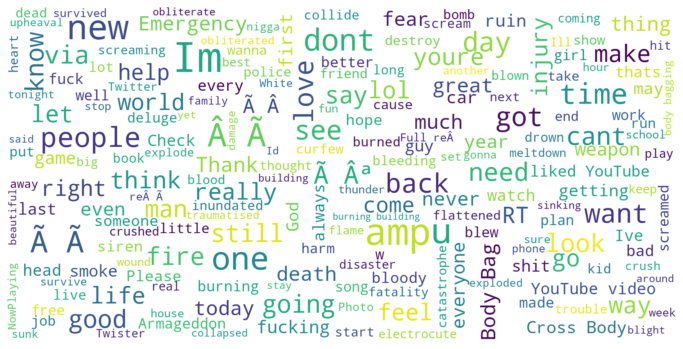

In [60]:
#Non Disaster Tweet wordcloud where target is 0
disaster_message = disaster[disaster.target == 0]
spam_string = []
for t in disaster_message.text:
    spam_string.append(t)
disaster_string = pd.Series(spam_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## <font color="blue">**DATA VISUALIZATION**</font>:

<Figure size 720x360 with 0 Axes>

Text(0, 0.5, 'Tweet Fallacy')

Text(0.5, 0, 'Number of Tweets')

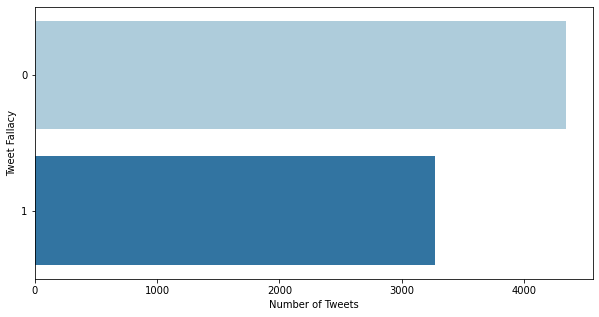

In [62]:
#Visualizing class distribution 
plt.figure(figsize=(10,5))
sns.countplot(y='target',data = disaster, palette="Paired")
plt.ylabel("Tweet Fallacy")
plt.xlabel("Number of Tweets")
plt.show()

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Tweet Fallacy')

Text(0, 0.5, 'Tweet Length by character')

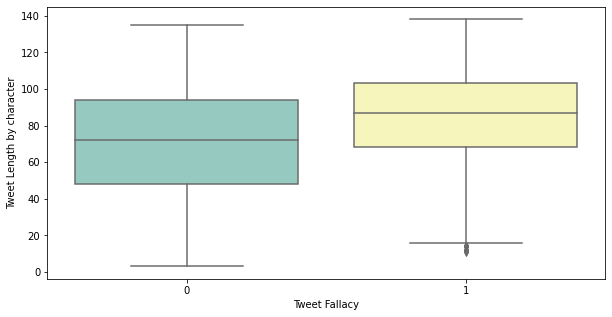

In [63]:
#Visualizing emails length by characaters
plt.figure(figsize=(10,5))
train_sent = disaster['text'].str.len()
sns.boxplot(x="target",y=train_sent,data=disaster,palette="Set3")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet Length by character")
plt.show()

In [64]:
# word_count
disaster['word_count'] = disaster['text'].apply(lambda x: len(str(x).split()))
disaster['word_count'] = disaster['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
disaster['unique_word_count'] = disaster['text'].apply(lambda x: len(set(str(x).split())))
disaster['unique_word_count'] = disaster['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
disaster['stop_word_count'] = disaster['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
disaster['stop_word_count'] = disaster['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
disaster['url_count'] = disaster['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
disaster['url_count'] = disaster['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
disaster['mean_word_length'] = disaster['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
disaster['mean_word_length'] = disaster['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
disaster['char_count'] = disaster['text'].apply(lambda x: len(str(x)))
disaster['char_count'] = disaster['text'].apply(lambda x: len(str(x)))

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'word_count Target Distribution in Training Set')

Text(0.5, 1.0, 'word_count Training & Test Set Distribution')

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'unique_word_count Target Distribution in Training Set')

Text(0.5, 1.0, 'unique_word_count Training & Test Set Distribution')

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'stop_word_count Target Distribution in Training Set')

Text(0.5, 1.0, 'stop_word_count Training & Test Set Distribution')

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'url_count Target Distribution in Training Set')

Text(0.5, 1.0, 'url_count Training & Test Set Distribution')

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'mean_word_length Target Distribution in Training Set')

Text(0.5, 1.0, 'mean_word_length Training & Test Set Distribution')

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'char_count Target Distribution in Training Set')

Text(0.5, 1.0, 'char_count Training & Test Set Distribution')

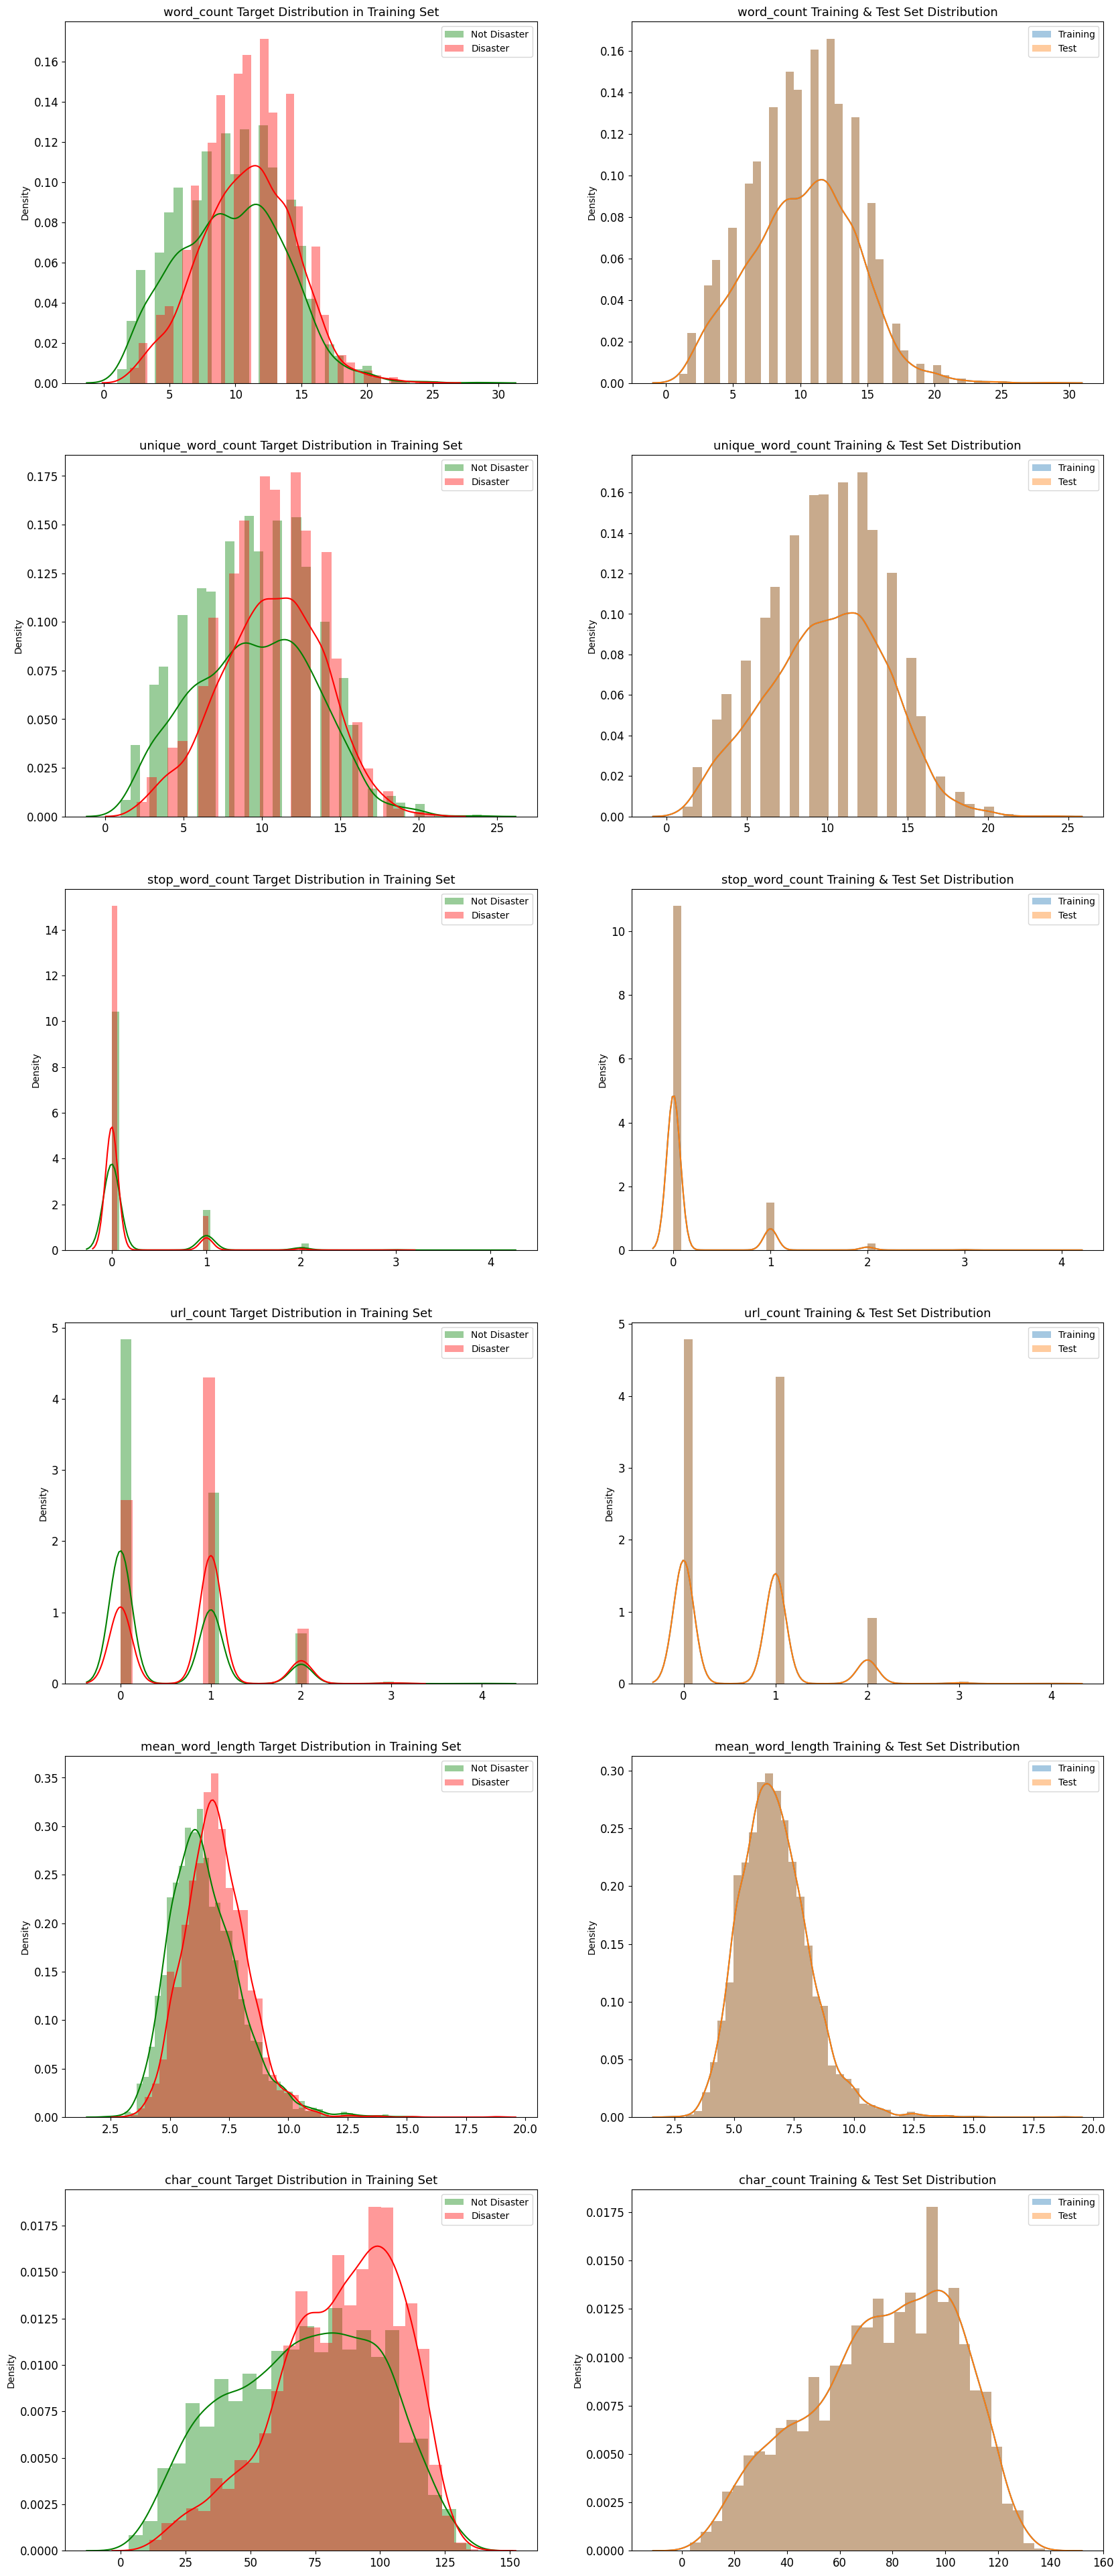

In [65]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
DISASTER_TWEETS = disaster['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(disaster.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(disaster.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(disaster[feature], label='Training', ax=axes[i][1])
    sns.distplot(disaster[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

#<font color='brown'><b>Model creation and prediction</b></font><br>
## BERT - Bidirectional Encoder Representations from Transformers

BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.

The best part about BERT is that we can use the BERT models to extract high quality language features from our text data.<br>
## <font color="blue">Train-Test Split and perform the classification task using the Naive Bayes classification model. <br> </font>

In [67]:
train_data = disaster.iloc[:4000]

len(train_data)

4000

In [68]:
test_data  = disaster.iloc[4001:len(disaster)]

len(test_data)

3612

## LOADING THE BERT MODEL:

In [69]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [70]:
x_train = tokenizer(
    text=train_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [71]:
x_train['input_ids'].shape

TensorShape([4000, 36])

In [72]:
x_train['attention_mask'].shape

TensorShape([4000, 36])

In [73]:
y_train = train_data.target.values
y_train.shape

(4000,)

In [74]:
train_data.target.value_counts()

0    2362
1    1638
Name: target, dtype: int64

## BUILDING THE MODEL ARCHITECTURE:

In [75]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

# for training bert our lr must be so small

In [76]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 36,                                            

In [77]:
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model.
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

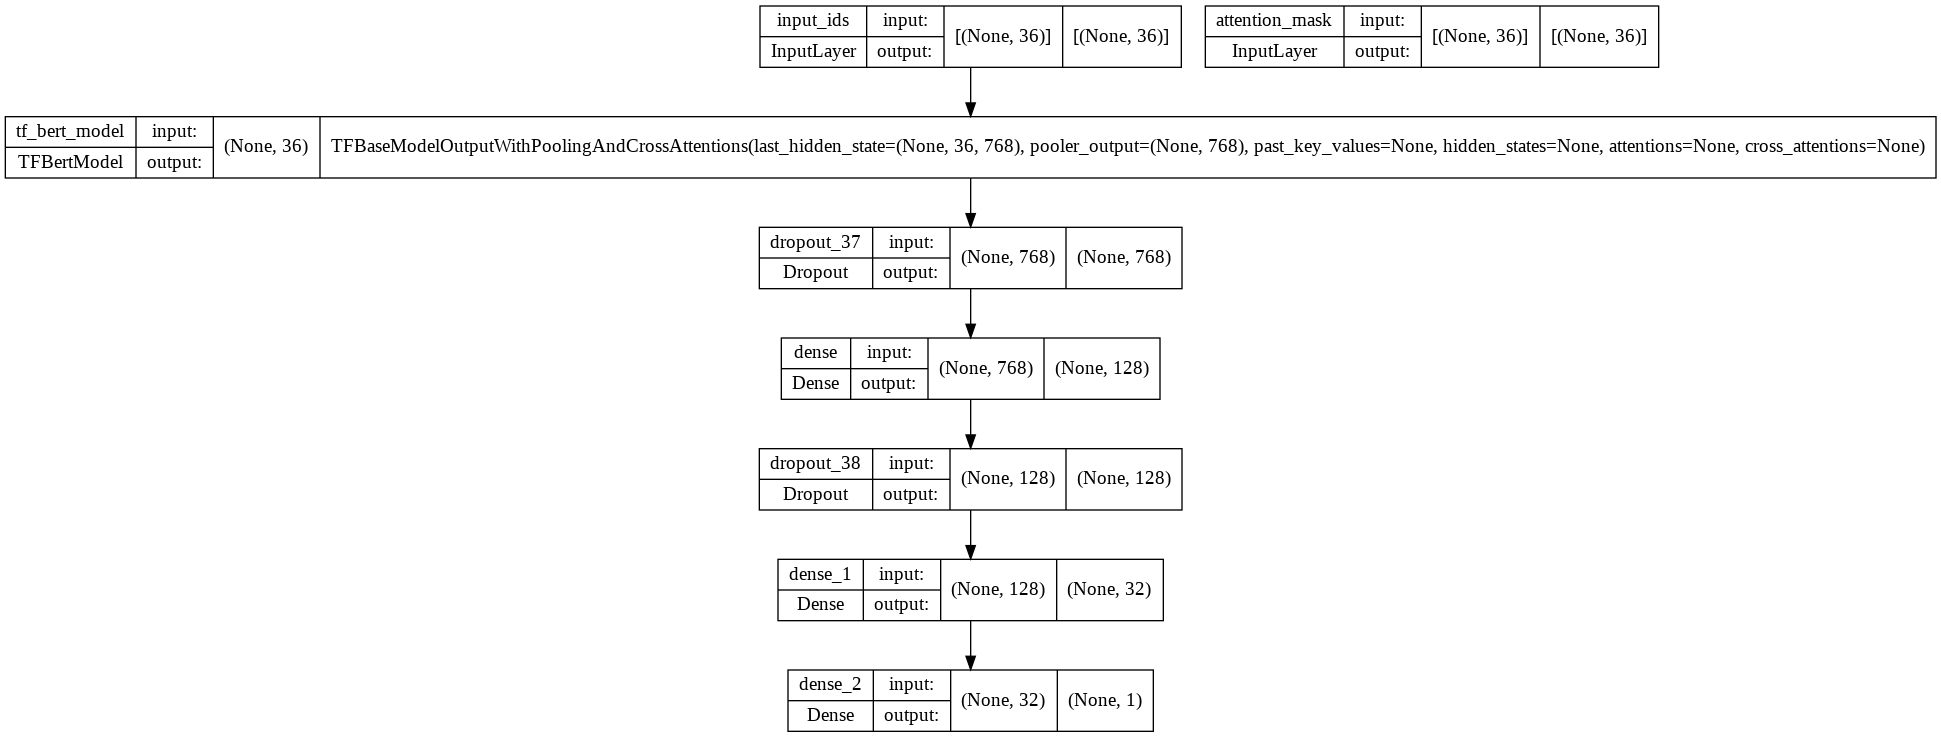

In [78]:
plot_model(model, show_shapes = True)

In [79]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#   validation_split = 0.1,
  epochs=1,
    batch_size=10
)

400/400 [==============================] - 1877s 5s/step - loss: 0.5376 - accuracy: 0.7385


## VISUALIZATION OF LOSS AND ACCURACY CURVE:

In [80]:
def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']
    loss = final.history['loss']
    epochs_plot = np.arange(1, len(loss) + 1)
    plt.clf()
    plt.plot(epochs_plot, acc, 'r', label='Accuracy')
    plt.plot(epochs_plot, loss, 'b:', label='Loss')
    plt.title('VISUALIZATION OF LOSS AND ACCURACY CURVE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

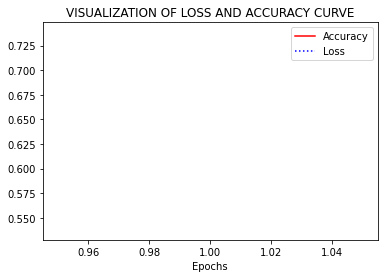

In [81]:
visual_accuracy_and_loss(final)

Text(0.5, 1.0, 'Accuracy Curve')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Loss Curve')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

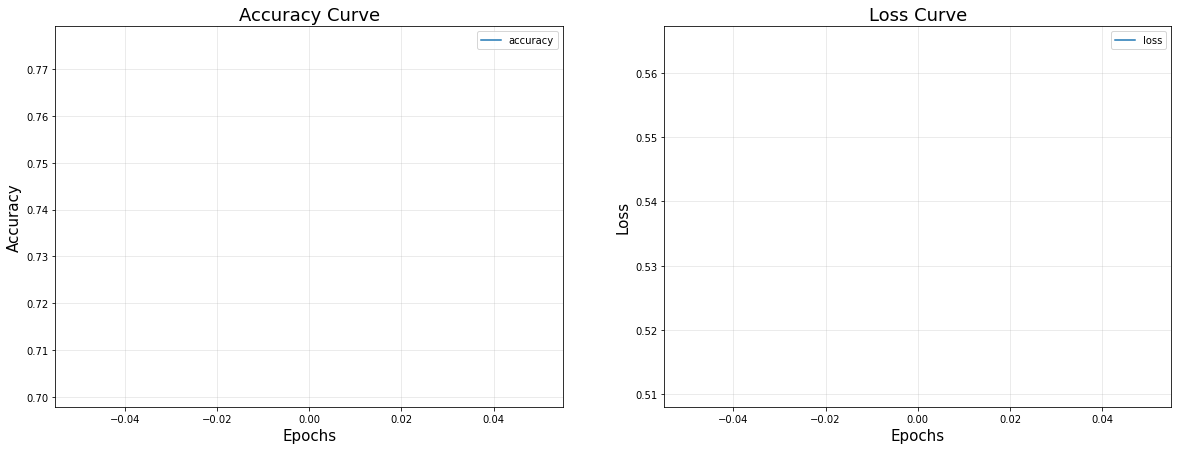

In [82]:
# Plot the loss and accuracy curves  

#Diffining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(final.epoch,final.history['accuracy'],label = "accuracy") # Accuracy curve 


plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(final.epoch,final.history['loss'],label="loss") # Loss curve 


plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [83]:
x_test = tokenizer(
    text=test_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

## PREDICTION:

In [84]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [85]:
y_predicted = np.where(predicted>0.5,1,0)

In [87]:
m = tf.keras.metrics.Accuracy()
m.update_state(test_data.target.values, np.round(predicted,0))
print('Final result: ', m.result().numpy())  

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=3612.0>

Final result:  0.79651165


## Accuracy of the model is - 79.65%